In [3]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
lattice_file = shift.get_6dsim_dir()\
                    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt")
lattice_df = lattice.read_lattice_file(lattice_file)

/opt/homebrew/Caskroom/miniforge/base/envs/env/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


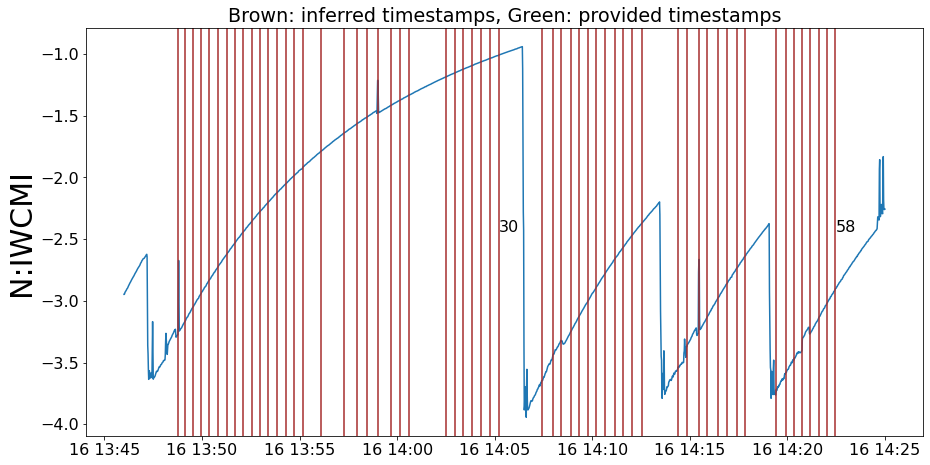

/opt/homebrew/Caskroom/miniforge/base/envs/env/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ilobach/fur/lattice/lattice.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)
/opt/homebrew/Caskroom/miniforge/base/envs/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [4]:
res_df_FLAT = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_FLAT = shift.get_acnet_data_df('all_acnet_data_FLAT_case_03_16_2020.csv')
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_case_03_16_2020.csv',
    show_plot=True
)
acnted_df_ROUND = shift.get_acnet_data_df('all_acnet_data_ROUND_case_03_16_2020.csv')
res_df_ROUND_Low_RF = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_ROUND_Low_RF = shift.get_acnet_data_df('all_acnet_data_ROUND_low_RF_case_03_16_2020.csv')

In [5]:
rdt = res_df_ROUND['real_datetime']
time_intervals = [(rdt[0], rdt[30]), (rdt[31], rdt[42]), (rdt[43], rdt[50]), (rdt[51], rdt[58])]
def in_time_intervals(row):
    t = row.name
    return True in [(t>ti[0] and t<ti[1]) for ti in time_intervals]
time_intervals

[(Timestamp('2020-03-16 13:48:45'), Timestamp('2020-03-16 14:05:13')),
 (Timestamp('2020-03-16 14:07:27'), Timestamp('2020-03-16 14:12:34')),
 (Timestamp('2020-03-16 14:14:23'), Timestamp('2020-03-16 14:17:51')),
 (Timestamp('2020-03-16 14:19:26'), Timestamp('2020-03-16 14:22:28'))]

### removing two outliers in ROUND data:

In [6]:
outliers_ROUND = ['RefCurve_2020-03-16_61_135841.Wfm.bin', 'RefCurve_2020-03-16_86_141506.Wfm.bin']
res_df_ROUND = res_df_ROUND[~res_df_ROUND['waveform_file'].isin(outliers_ROUND)]

In [7]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")

# Loosses in the long cable cna be accounted for here by a factor `losses`

In [8]:
losses = 1.0
sum_channel_to_photoelectrons =\
    1/losses*get_from_config('sum_channel_to_photoelectrons')
new_meas_photons_per_electron =\
    1/losses*get_from_config("Measured_photons_per_electron")
new_meas_photons_per_electron

0.008798823311458544

In [9]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [10]:
size_names = ['Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']
def var_theor(x, M):
    return x+1/M*x**2

In [11]:
for fluctuations_df in [res_df_FLAT, res_df_ROUND, res_df_ROUND_Low_RF]:
    N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
    varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
    fluctuations_df['N'] = N
    fluctuations_df['varN'] = varN
    fluctuations_df['varN_theor'] = fluctuations_df.apply(lambda row: var_theor(row['N'],Mfunc(row['Sigma_um_X'], row['Sigma_um_Y'], row['N:IWCMBE'])),axis=1) 

In [12]:
# plt.plot(res_df_FLAT["ch2_amplitude"],res_df_FLAT["var_of_ch1_amplitude"] ,'.', label="FLAT")
# plt.plot(res_df_ROUND["ch2_amplitude"],res_df_ROUND["var_of_ch1_amplitude"] ,'.', label="ROUND")
# plt.plot(res_df_ROUND_Low_RF["ch2_amplitude"],res_df_ROUND_Low_RF["var_of_ch1_amplitude"] ,'.', label="ROUND_LONG")
# x_f = np.linspace(0,max(res_df_FLAT["ch2_amplitude"]),1000)
# plt.xlabel("Sum channel amplitude, V")
# plt.ylabel("Variance of the difference channel amplitude, V$^2$")
# plt.title(r"Shift 03-16-2020")
# plt.legend()
# plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.png"), bbox_inches='tight')
# plt.show()

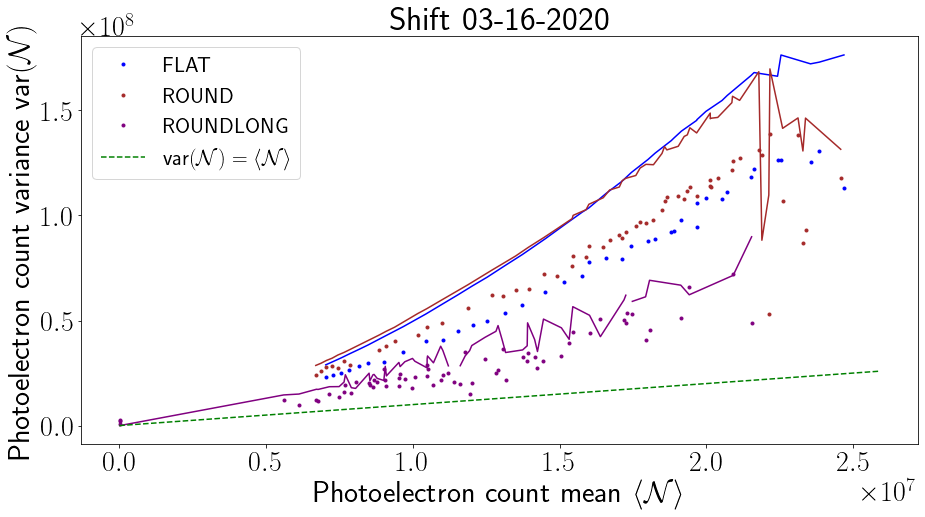

In [13]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"FLAT": 'blue', "ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'FLAT': res_df_FLAT, 'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

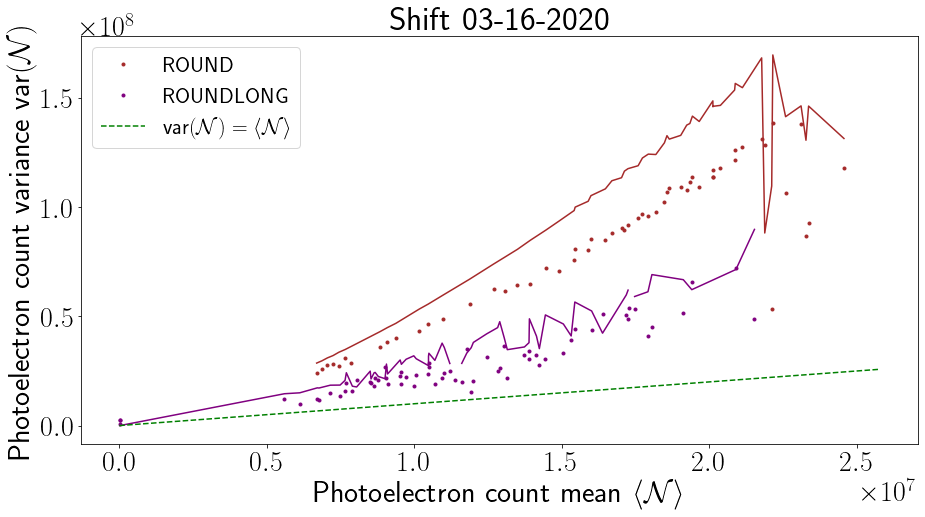

In [14]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

In [15]:
# acnet_df_ROUND_with_bunch_sizes = get_acnet_df_with_bunch_sizes(
#     shift,
#     "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
#     acnted_df_ROUND
# )

In [16]:
# acnet_df_ROUND_with_bunch_sizes.to_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_case_03_16_2020.csv'))

In [17]:
acnet_df_ROUND_with_bunch_sizes = pd.read_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_case_03_16_2020.csv'), index_col=0, parse_dates=True)
acnet_df_ROUND_with_bunch_sizes_in_time_intervals = acnet_df_ROUND_with_bunch_sizes[acnet_df_ROUND_with_bunch_sizes.apply(in_time_intervals, axis=1).values]

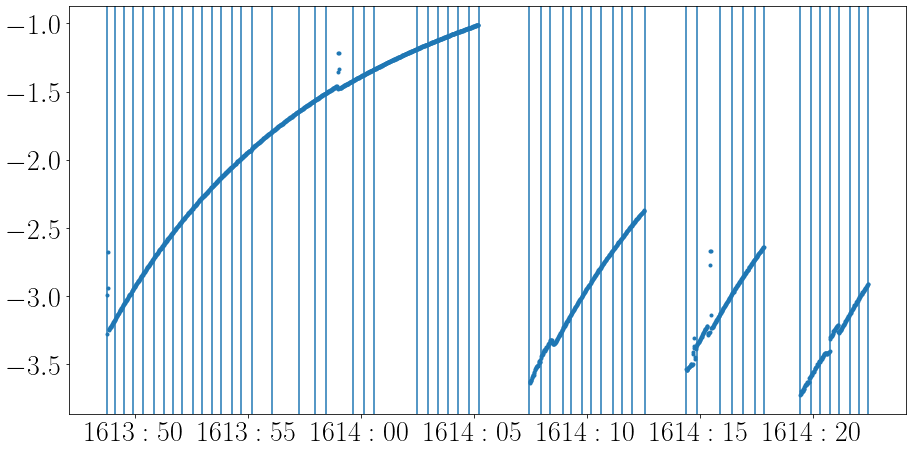

In [18]:
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND['real_datetime']:
    ax.axvline(t)
plt.show()

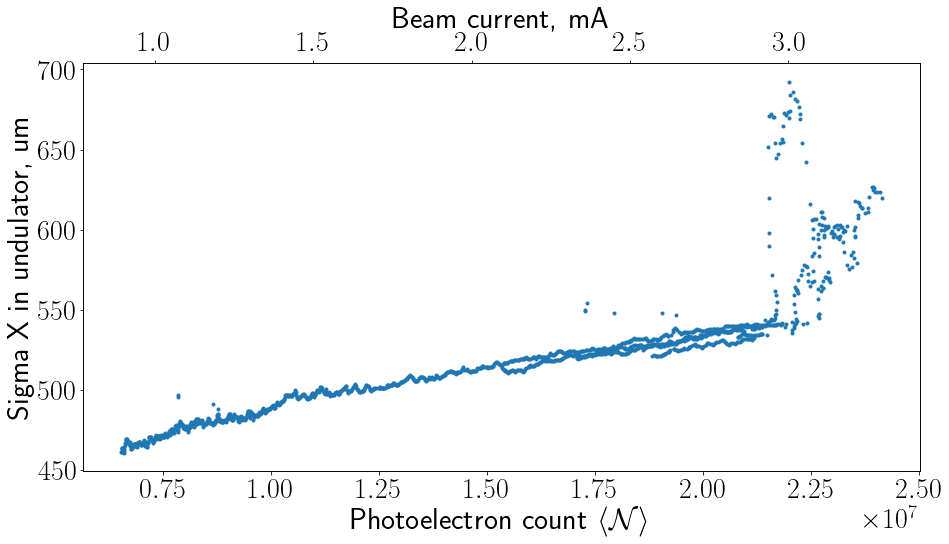

In [19]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

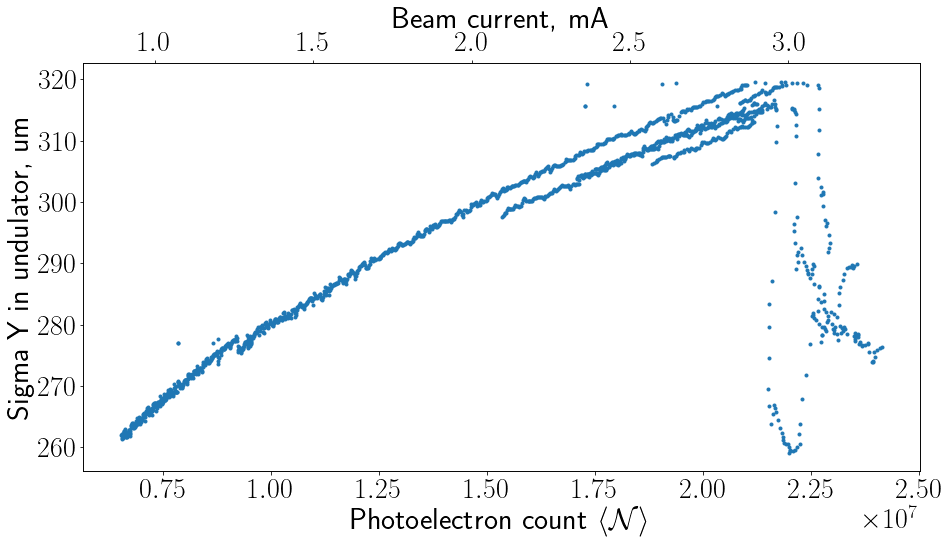

In [20]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

# Leaving only first injection:

In [21]:
first_injection = acnet_df_ROUND_with_bunch_sizes_in_time_intervals[acnet_df_ROUND_with_bunch_sizes_in_time_intervals.index<time_intervals[0][1]]
second_injection = acnet_df_ROUND_with_bunch_sizes_in_time_intervals[
    acnet_df_ROUND_with_bunch_sizes_in_time_intervals.index<time_intervals[1][1]]
second_injection = second_injection[second_injection.index>time_intervals[1][0]]
df = first_injection

In [22]:
def get_ex_ey_vals(row):
    cameras_df = lattice.get_cameras_df(
                            lattice_df,
                            row[lattice.acnet_devices_X].values,
                            row[lattice.acnet_devices_Y].values)
    es = lattice.get_e_um_X_dict(cameras_df, row["dp/p"])
    eys = lattice.get_e_um_Y_dict(cameras_df)
    es.update(eys)
    return es 
ex_ey_by_camera_df = first_injection.apply(
        get_ex_ey_vals, axis=1, result_type='expand')
first_injection = pd.concat([first_injection, ex_ey_by_camera_df], axis=1)

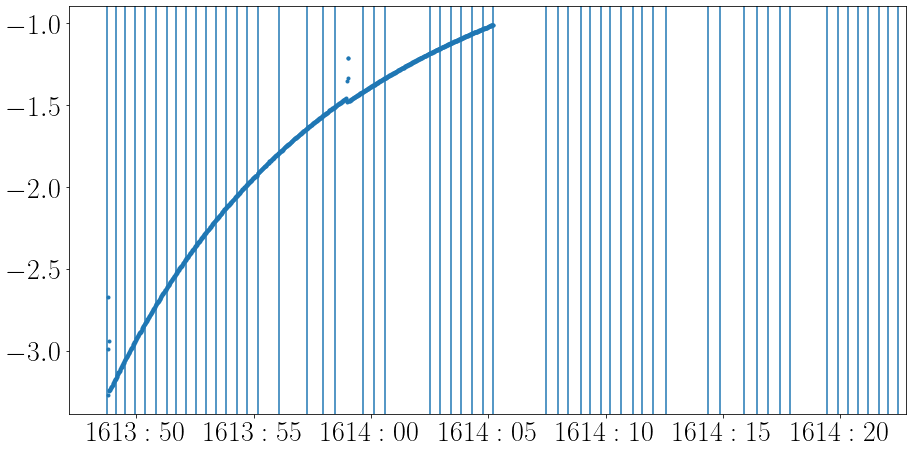

In [23]:
df = first_injection
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND['real_datetime']:
    ax.axvline(t)
plt.show()

In [24]:
# Add traces
df = second_injection
df['time'] = df.index.astype(np.int64)
df['time'] = (df['time']-df['time'].values[0])*1e-9
df = df[df['time']<51]
df53 = df[df['time']>10]


Is = -df53["N:IWCMI_recalibrated_to_IWCMI_absolute"]
I0 = Is.mean()
dI0 = -(Is.max()-Is.min())
dt0 = (df53['time'].max()-df53['time'].min())
lt0 = -I0/(dI0/dt0)
I0, lt0

(3.054319174390001, 597.6982630658856)

In [25]:
import statsmodels.api as sm

In [26]:
def get_life_time_for_piece(df53):
    X = sm.add_constant(df53['time'])
    res = sm.OLS(df53["N:IWCMI_recalibrated_to_IWCMI_absolute"], X).fit()
    slope = res.params['time']
    slope_err = res.bse['time']
    rel_err = slope_err/slope
    I0 = -df53["N:IWCMI_recalibrated_to_IWCMI_absolute"].mean()
    lt = I0/slope
    return {"I (mA)": I0, "Beam life time (Sec)": lt, "Life time error (Sec)": lt*rel_err}

In [27]:
df0 = pd.DataFrame(get_life_time_for_piece(df53), index=[0])
df0

I (mA)  Beam life time (Sec)  Life time error (Sec)
0  3.054319             616.99797              10.403415

In [28]:
df = first_injection
df['time'] = df.index.astype(np.int64)
df['time'] = (df['time']-df['time'].values[0])*1e-9
before = df[df['time'].between(4,610)]
after = df[df['time']>618]

res_list = []
for df, npts in zip([before, after], [15,5]):
    Imin = -(df['N:IWCMI_recalibrated_to_IWCMI_absolute'].max())
    Imax = -(df['N:IWCMI_recalibrated_to_IWCMI_absolute'].min())
    dI = (Imax-Imin)/npts
    df['I/dI'] = (((-df['N:IWCMI_recalibrated_to_IWCMI_absolute']-Imin)/dI).values).astype(int)
    idimax = df['I/dI'].max()
    df['I/dI'] = np.where(df['I/dI'] < idimax, df['I/dI'], idimax-1)
    df = df.groupby('I/dI').apply(get_life_time_for_piece).apply(pd.Series)
    res_list.append(df)
df1, df2 = res_list
tot_lt_df = pd.concat([df0, df1, df2]).reset_index(drop=True)
tot_lt_df
tot_lt_df['rel_err'] = (lambda x: x['Life time error (Sec)']/x['Beam life time (Sec)'])(tot_lt_df)
tot_lt_df

<ipython-input-28-ea4f3acca79e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['I/dI'] = (((-df['N:IWCMI_recalibrated_to_IWCMI_absolute']-Imin)/dI).values).astype(int)
<ipython-input-28-ea4f3acca79e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['I/dI'] = np.where(df['I/dI'] < idimax, df['I/dI'], idimax-1)
<ipython-input-28-ea4f3acca79e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

I (mA)  Beam life time (Sec)  Life time error (Sec)   rel_err
0   3.054319            616.997970              10.403415  0.016861
1   1.342791            855.262883               2.855087  0.003338
2   1.448153            833.730795               2.810366  0.003371
3   1.554109            818.474411               2.740348  0.003348
4   1.660011            778.153823               6.691100  0.008599
5   1.765430            781.812242               3.632625  0.004646
6   1.869124            779.774705               3.673745  0.004711
7   1.973523            752.282499               3.476814  0.004622
8   2.079546            738.399703               3.756410  0.005087
9   2.184589            723.913997               5.267137  0.007276
10  2.289808            710.420922               3.470440  0.004885
11  2.396066            680.699384               5.075517  0.007456
12  2.502820            677.871238               5.805409  0.008564
13  2.606384            669.525097               7.367068  0.011003
14  2.709293            676.201133               5.537945  0.008190
15  2.819134            683.750538               7.466355  0.010920
16  0.933185           1029.121958               3.634273  0.003531
17  1.015785            992.771790               2.951517  0.002973
18  1.097891            961.764601               2.520353  0.002621
19  1.179766            942.222138               3.285824  0.003487
20  1.261738            915.723464               2.649905  0.002894

In [29]:
df = second_injection
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'],
                         y=df["N:IWCMI_recalibrated_to_IWCMI_absolute"],
                    mode='markers',
                    name='Original data'))
fig.show()

<ipython-input-30-1867f1116b27>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



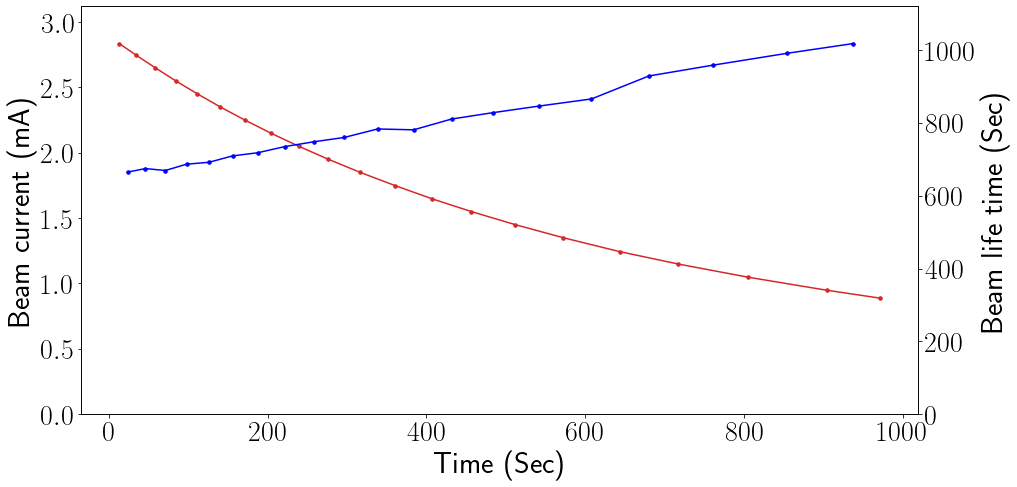

In [30]:
import plotly.graph_objects as go
df = first_injection
df['time'] = df.index.astype(np.int64)
df['time'] = (df['time']-df['time'].values[0])*1e-9
before = df[df['time'].between(4,610)]
after = df[df['time']>618]
scale = 0.98
after["N:IWCMI_recalibrated_to_IWCMI_absolute"] =\
    scale*after["N:IWCMI_recalibrated_to_IWCMI_absolute"]
df_adj = before.append(after)
import plotly.graph_objects as go
fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=df['time'],
                         y=df["N:IWCMI_recalibrated_to_IWCMI_absolute"],
                    mode='markers',
                    name='Original data'))
fig.add_trace(go.Scatter(x=df_adj['time'],
                         y=df_adj["N:IWCMI_recalibrated_to_IWCMI_absolute"],
                    mode='markers',
                    name='Adjusted'))

fig.show()


dI = 0.1
df_adj['I/dI'] = ((df_adj['N:IWCMI_recalibrated_to_IWCMI_absolute']/dI).values).astype(int)
df_adj = df_adj.groupby('I/dI').mean()
ts = df_adj['time'].values
Is = -df_adj['N:IWCMI_recalibrated_to_IWCMI_absolute'].values
Is_lt = (Is[:-1]+Is[1:])/2
ts_lt = (ts[1:]+ts[:-1])/2
dts_lt = (ts[:-1]-ts[1:])
dIs = -(Is[:-1]-Is[1:])
lts = Is_lt/(dIs/dts_lt)
fig, ax = plt.subplots()
ax.plot(ts, Is,'.-',markersize=7, color='tab:red')
ax.set_ylim(0, 1.1*max(Is))
ax.set_ylabel("Beam current (mA)")
ax.set_xlabel("Time (Sec)")
ax1 = ax.twinx()
ax1.plot(ts_lt, lts,'.-',markersize=7, color='blue')
ax1.set_ylim(0, 1.1*max(lts))
ax1.set_ylabel("Beam life time (Sec)")
plt.show()
lt_df = pd.DataFrame({"I (mA)": Is_lt, "Beam life time (Sec)": lts})
lt_df =  pd.DataFrame({"I (mA)": [I0], "Beam life time (Sec)": [lt0]}).append(lt_df)
lt_df = lt_df.reset_index(drop=True)

(0.0, 1200.0)

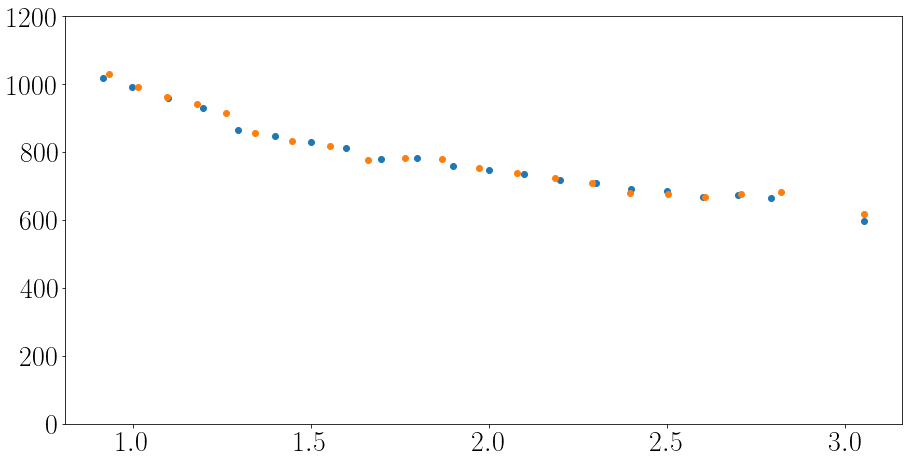

In [31]:
fig, ax = plt.subplots()
ax.plot(lt_df['I (mA)'], lt_df['Beam life time (Sec)'], 'o')
ax.errorbar(tot_lt_df['I (mA)'], tot_lt_df['Beam life time (Sec)'], 
            yerr=tot_lt_df["Life time error (Sec)"], linestyle='none', marker='o')
ax.set_ylim(0, 1200)

In [32]:
fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=lt_df['I (mA)'],
                         y=lt_df['Beam life time (Sec)'],
                    mode='markers',
                    name='Original data'))
fig.add_trace(go.Scatter(x=tot_lt_df['I (mA)'],
                         y=tot_lt_df['Beam life time (Sec)'],
                    mode='markers',
                    name='Adjusted'))
fig.show()

In [33]:
lt_df.to_csv(shift.get_results_dir().fi("life_time_round_03_16_2020.csv"))

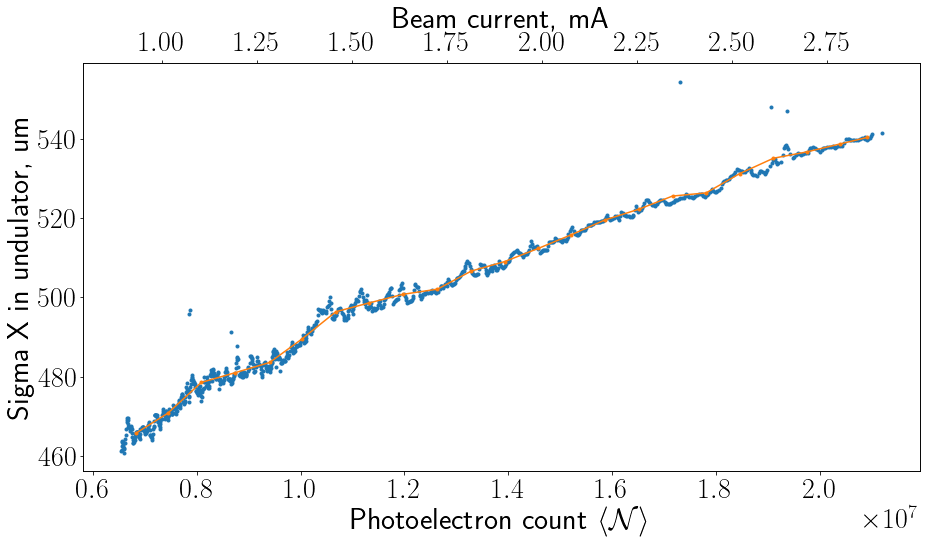

In [34]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save = pd.DataFrame(
    {"N": -df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
     "Sigma_um_X": df['Sigma_um_X']
    })
sx_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_X'], bounds_error=False, fill_value="extrapolate")
sx_interp = sx_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sx_err_stat = np.std(first_injection['Sigma_um_X'].values-sx_interp)
ax.plot(photoel, df['Sigma_um_X'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [36]:
sx_func(2.00 * i_to_photoel)

array(512.69764782)

In [37]:
sx_err_stat

2.0237091068609283

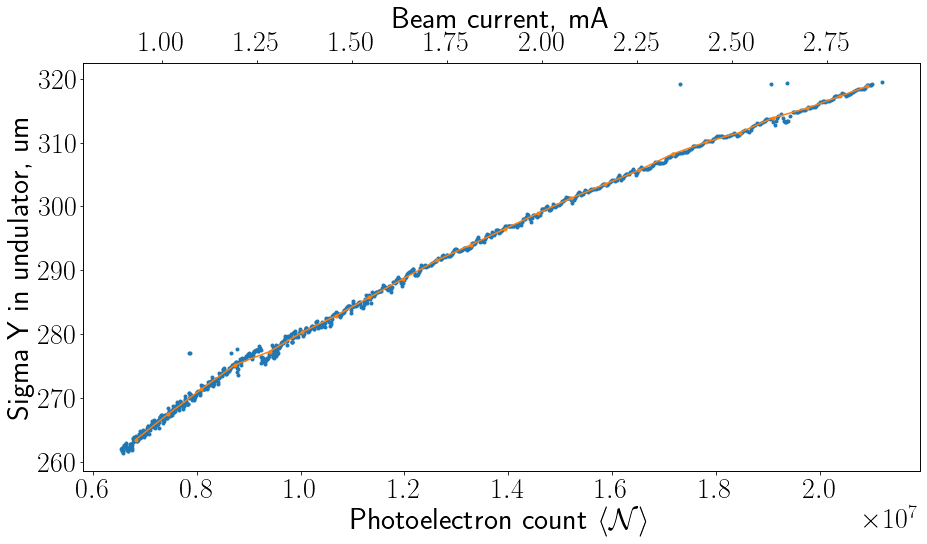

In [38]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save["Sigma_um_Y"] = df['Sigma_um_Y']
sy_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_Y'], bounds_error=False, fill_value="extrapolate")
sy_interp = sy_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sy_err_stat = np.std(first_injection['Sigma_um_Y'].values-sy_interp)
ax.plot(photoel, df['Sigma_um_Y'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [40]:
sy_func(2.00 * i_to_photoel)

array(299.20151358)

In [41]:
sy_err_stat

0.6831758341120086

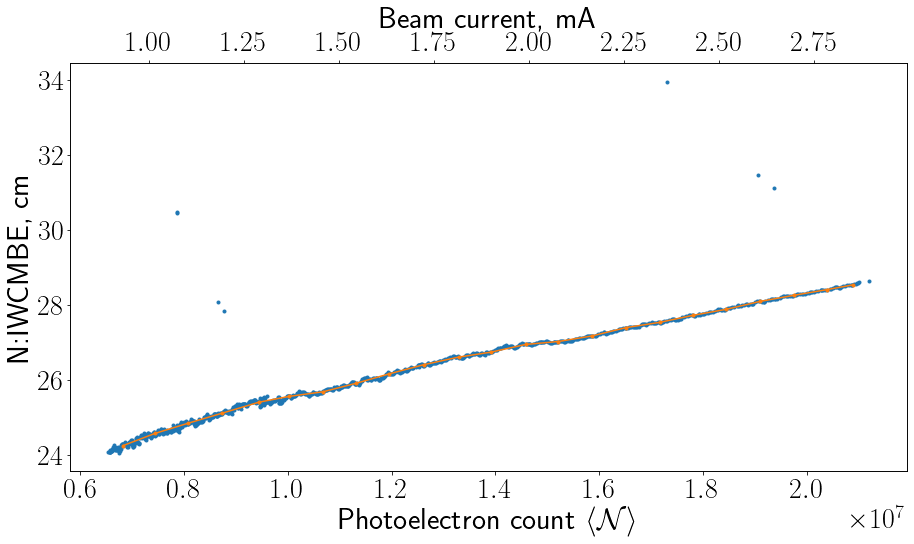

In [42]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBE'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['sz_um'] = 1e4*df['N:IWCMBE'] 
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IWCMBE'], bounds_error=False, fill_value="extrapolate")
sz_interp = sz_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IWCMBE'].values-sz_interp))
ax.plot(photoel, df['N:IWCMBE'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBE, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [43]:
sz_err_stat

0.09119185892226402

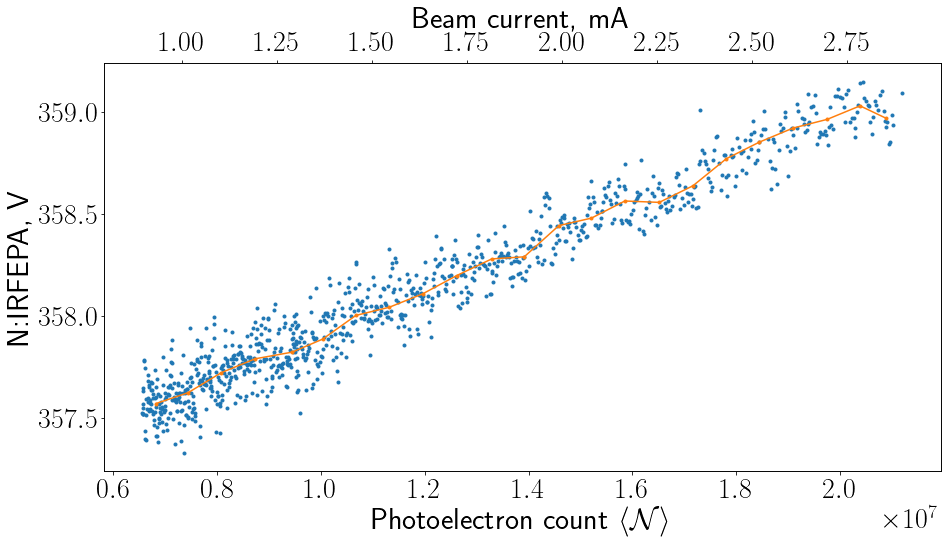

In [44]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IRFEPA'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['N:IRFEPA'] = df['N:IRFEPA'] 
Vrf_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IRFEPA'], bounds_error=False, fill_value="extrapolate")
Vrf_interp = Vrf_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
Vrf_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IRFEPA'].values-Vrf_interp))
ax.plot(photoel, df['N:IRFEPA'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IRFEPA, V")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

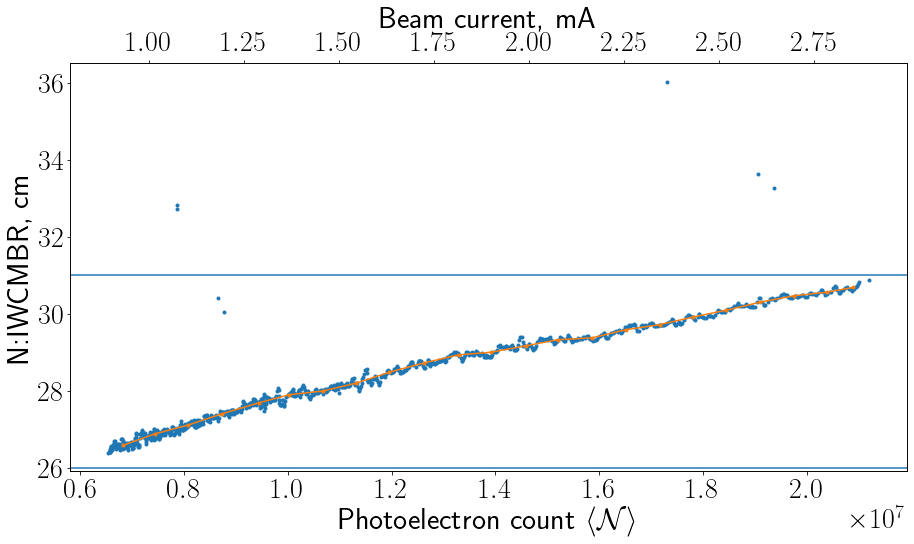

In [45]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBR'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['sz_cm_rms'] = df['N:IWCMBR'] 
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IWCMBR'], bounds_error=False, fill_value="extrapolate")
sz_interp = sz_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IWCMBR'].values-sz_interp))
ax.plot(photoel, df['N:IWCMBR'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBR, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
ax.axhline(26)
ax.axhline(31)
plt.show()

In [47]:
sz_func(2.00 * i_to_photoel)

array(29.18395868)

In [82]:
.2918395868 / 3e8

9.727986226666666e-10

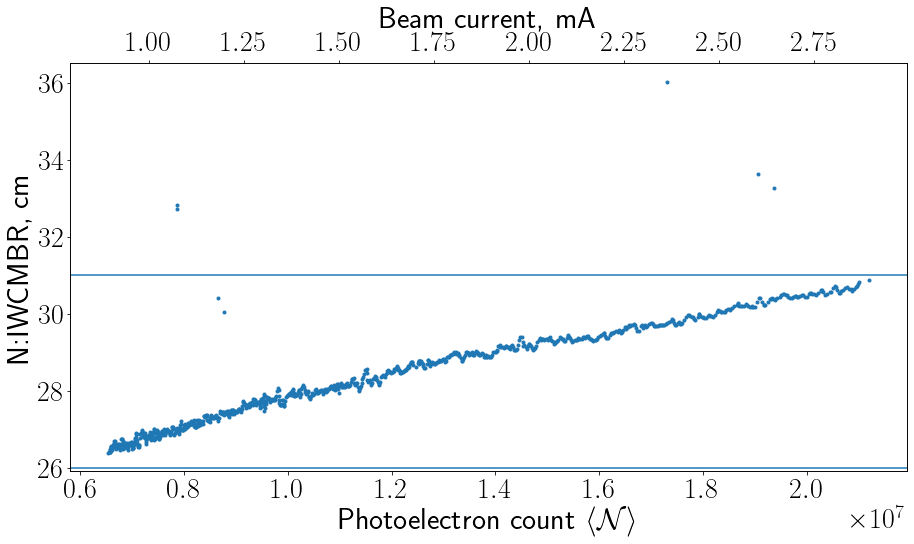

In [46]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBR'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBR, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
ax.axhline(26)
ax.axhline(31)
plt.show()

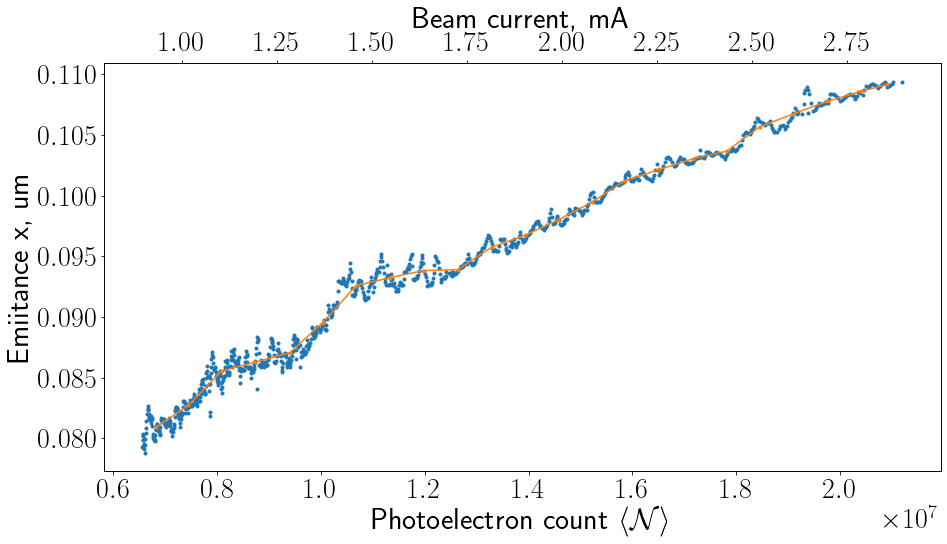

In [48]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['ex_um'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Emiitance x, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['ex_um'] = df['ex_um']
ex_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['ex_um'], bounds_error=False, fill_value="extrapolate")
ex_interp = ex_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
ex_err_stat = np.std(first_injection['ex_um'].values-ex_interp)
ax.plot(photoel, df['ex_um'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

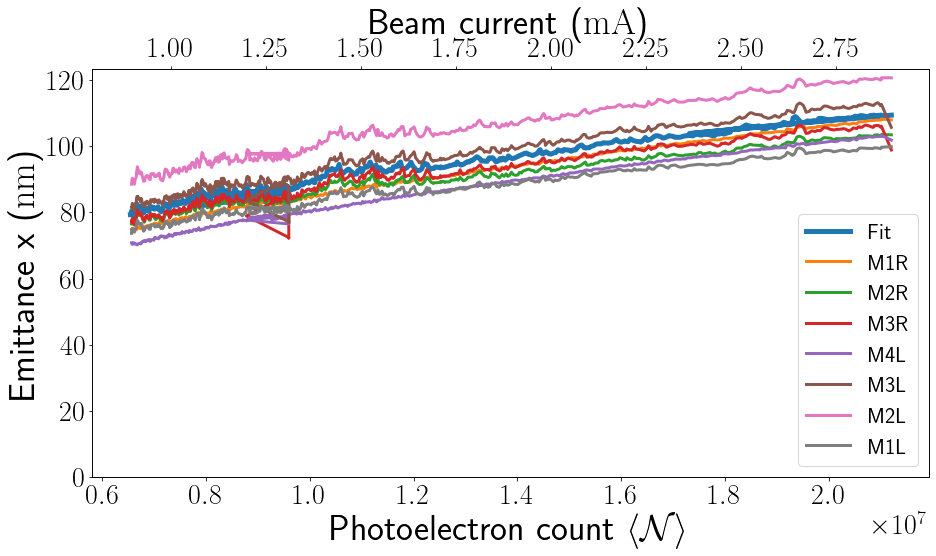

In [49]:
df = first_injection
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 36
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, 1000*df['ex_um'],'-', linewidth=5 , label='Fit')
for cam in lattice.active_cameras:
    ax.plot(photoel.rolling(4).max(), 1000*df['e_um_X_'+cam],
            linestyle='-', linewidth=3, label=cam)
# ax2 = ax.twinx()
# ax2.plot(photoel, df['N:IWCMBR'],'.', label='RMS bunch length')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$", fontsize=fs)
ax.set_ylabel("Emittance x (\SI{}{nm})", fontsize=fs)
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc='lower right')
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.savefig(shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [50]:
camsx = ['e_um_X_'+cam for cam in lattice.active_cameras]
def get_x_errors_one_row(row):
    exfit = row['ex_um']
    excams = row[camsx]
    higher = excams[excams>exfit]
    lower = excams[excams<exfit]
    errhigher = np.sqrt(np.mean((higher-exfit)**2))
    errlower = np.sqrt(np.mean((lower-exfit)**2))
    return {'ex_err_high':errhigher, 'ex_err_low':errlower}
ex_errors = df.apply(get_x_errors_one_row, axis=1, result_type='expand')
ex_err_plus, ex_err_minus = 1000*ex_errors.mean()
ex_err_plus, ex_err_minus

(7.617578064178959, 5.735226390971804)

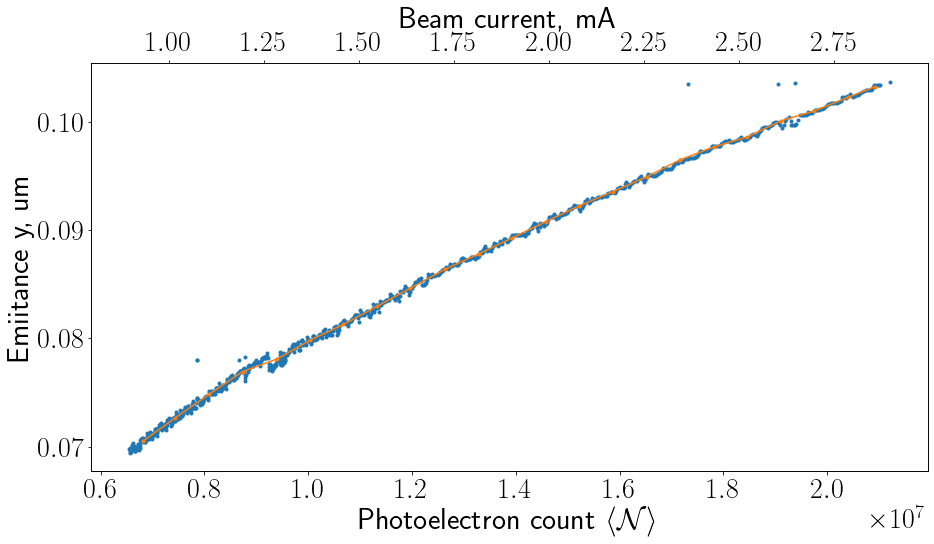

In [51]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['ey_um'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Emiitance y, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['ey_um'] = df['ey_um']
ey_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['ey_um'], bounds_error=False, fill_value="extrapolate")
ey_interp = ey_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
ey_err_stat = np.std(first_injection['ey_um'].values-ey_interp)
ax.plot(photoel, df['ey_um'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

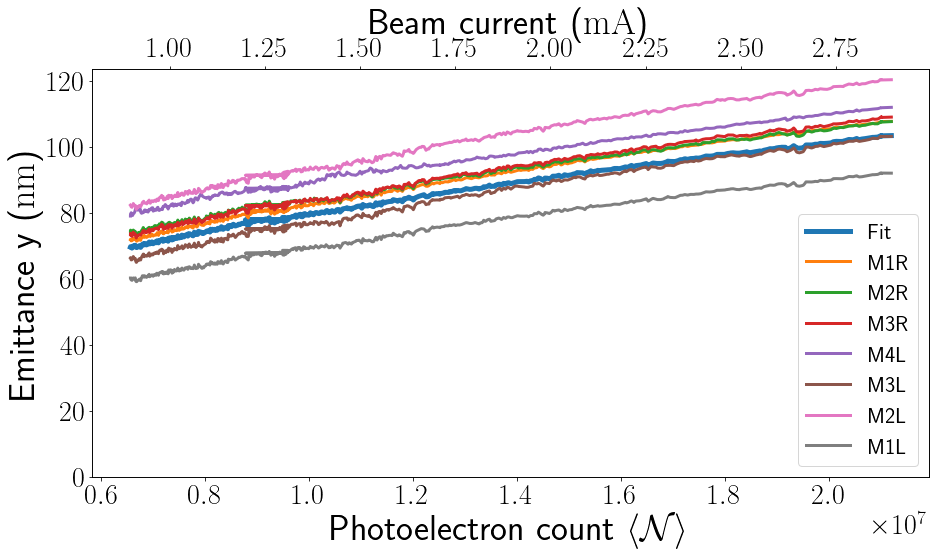

In [52]:
df = first_injection
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 36
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel.rolling(4).max(), 1000*df['ey_um'],'-', linewidth=5 , label='Fit')
for cam in lattice.active_cameras:
    ax.plot(photoel.rolling(4).max(), 1000*df['e_um_Y_'+cam],
            linestyle='-', linewidth=3, label=cam)
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$", fontsize=fs)
ax.set_ylabel("Emittance y (\SI{}{nm})", fontsize=fs)
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc='lower right')
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.savefig(shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [53]:
camsy = ['e_um_Y_'+cam for cam in lattice.active_cameras]
def get_y_errors_one_row(row):
    eyfit = row['ey_um']
    eycams = row[camsy]
    higher = eycams[eycams>eyfit]
    lower = eycams[eycams<eyfit]
    errhigher = np.sqrt(np.mean((higher-eyfit)**2))
    errlower = np.sqrt(np.mean((lower-eyfit)**2))
    return {'ey_err_high':errhigher, 'ey_err_low':errlower}
ey_errors = df.apply(get_y_errors_one_row, axis=1, result_type='expand')
ey_err_plus, ey_err_minus = 1000*ey_errors.mean()
ey_err_plus, ey_err_minus

(8.280217606256768, 7.566735463991406)

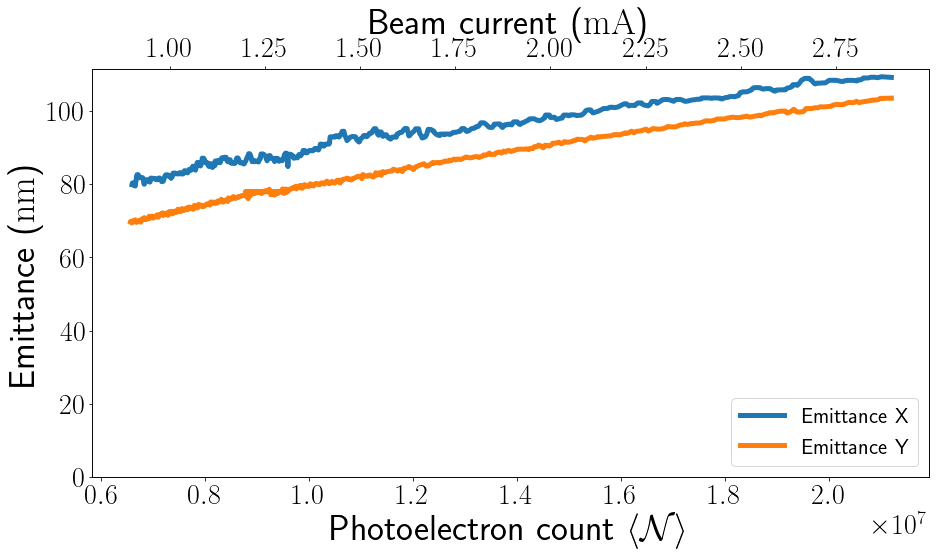

In [54]:
df = first_injection
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 36
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel.rolling(10).max(), 1000*df['ex_um'].rolling(4).max(),'-', linewidth=5 , label='Emittance X')
ax.plot(photoel.rolling(4).max(), 1000*df['ey_um'],'-', linewidth=5 , label='Emittance Y')

ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$", fontsize=fs)
ax.set_ylabel("Emittance (\SI{}{nm})", fontsize=fs)
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc='lower right')
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.savefig(shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [74]:
q = pd.DataFrame({'I':photoel.rolling(10).max() / i_to_photoel, 'ex':1000*df['ex_um'].rolling(4).max()})

In [75]:
ex0 = q[np.abs(q['I']-2.00) < 0.02].mean()['ex']
ex0

98.33066567629335

In [76]:
q = pd.DataFrame({'I':photoel.rolling(4).max() / i_to_photoel, 'ey': 1000*df['ey_um']})

In [78]:
ey0 = q[np.abs(q['I']-2.00) < 0.02].mean()['ey']
ey0

90.7910618989577

In [79]:
(ex0 + ey0) / 2

94.56086378762552

In [81]:
9.1e-6 * 29.18395868

0.000265574023988

In [55]:
df.describe()

N:ITC1RSV   N:ITC1RSH   N:ITC2RSV   N:ITC2RSH   N:ITC3RSV   N:ITC3RSH  \
count  987.000000  987.000000  987.000000  987.000000  987.000000  987.000000   
mean   403.461262  180.528329  162.781671  542.316104  244.150965  706.081110   
std     23.707386    9.519367    8.755053   22.051067   14.010200   31.051636   
min    366.855590  165.908400  148.873090  504.573000  221.775500  652.835020   
25%    383.640228  172.723653  155.551400  524.469510  232.512350  680.930785   
50%    399.376755  179.118300  160.677005  543.372495  241.202410  707.143980   
75%    422.930858  188.138055  170.080730  558.056243  255.747875  729.796248   
max    450.873900  199.830990  180.712910  586.966000  272.539400  767.367000   

          N:ITC4RSV  N:ITC4RSH   N:ITC4LSV   N:ITC4LSH   N:ITC3LSV  \
count  9.870000e+02    987.000  987.000000  987.000000  987.000000   
mean   1.059989e+02    732.771  484.644866  426.030443  240.326652   
std    2.843612e-14      0.000   23.366846   22.999321   15.599501   
min    1.059989e+02    732.771  447.181700  390.309390  215.425400   
25%    1.059989e+02    732.771  466.092345  407.097138  227.126050   
50%    1.059989e+02    732.771  482.578220  422.685000  236.921510   
75%    1.059989e+02    732.771  502.965990  444.571748  253.380950   
max    1.059989e+02    732.771  532.507020  472.266600  271.746090   

        N:ITC3LSH   N:ITC2LSV   N:ITC2LSH   N:ITC1LSV   N:ITC1LSH    N:IWCMBF  \
count  987.000000  987.000000  987.000000  987.000000  987.000000  987.000000   
mean   724.659586  162.481969  580.702633  490.069649  186.341402   59.725896   
std     32.428560    9.057399   24.306647   30.771833    7.583646    2.934103   
min    669.916020  148.117490  538.787050  441.421600  173.213000   55.415281   
25%    698.465760  154.843150  560.720000  463.771590  180.145978   57.737712   
50%    725.128970  160.686490  581.862975  484.313720  186.685000   58.859168   
75%    749.612762  170.001328  598.602505  515.850755  192.018600   61.576582   
max    789.518980  180.630310  629.398010  551.085020  201.752900   85.897266   

         N:IWCMBR    N:IWCMBP     N:IWCMI    N:IRFEPA    N:IRFEPP    N:IWCMBE  \
count  987.000000  987.000000  987.000000  987.000000  987.000000  987.000000   
mean    28.302970  -84.065073   -1.828817  358.109946  102.203770   26.034175   
std      1.261724    0.152415    0.627901    0.443291    0.212149    1.296732   
min     26.389055  -84.407471   -3.273680  357.331375  101.603400   24.067336   
25%     27.224252  -84.188351   -2.294313  357.751159  102.047164   24.961900   
50%     28.095423  -84.088958   -1.677502  358.015227  102.245310   25.781221   
75%     29.298729  -83.957697   -1.291089  358.447725  102.380875   27.011241   
max     36.036870  -83.539501   -1.010110  359.146974  102.609346   33.941221   

         N:IWCMBM    N:IWCMBG    N:IWCMIG    N:IBEAMA  N:IRFEPC      N:IRFEAT  \
count  987.000000  987.000000  987.000000  987.000000     987.0  9.870000e+02   
mean    21.504921   25.260420   -1.800558   -1.678803      42.5 -8.800000e+00   
std      1.051213    1.283536    0.617301    0.565007       0.0  1.777257e-15   
min     19.947252   23.353572   -3.222574   -2.957565      42.5 -8.800000e+00   
25%     20.627302   24.292340   -2.256558   -2.099123      42.5 -8.800000e+00   
50%     21.291750   24.927869   -1.649184   -1.552415      42.5 -8.800000e+00   
75%     22.310263   26.146245   -1.272656   -1.189000      42.5 -8.800000e+00   
max     28.565972   35.545480   -0.996127   -0.936343      42.5 -8.800000e+00   

         N:IRFEFP    N:IRFECG  N:IWCMI_recalibrated_to_IWCMI_absolute  \
count  987.000000  987.000000                              987.000000   
mean     8.450570    0.260006                               -1.617707   
std      0.023353    0.000373                                0.555419   
min      8.411918    0.259419                               -2.895780   
25%      8.430000    0.259700                               -2.029467   
50%      8.441936  

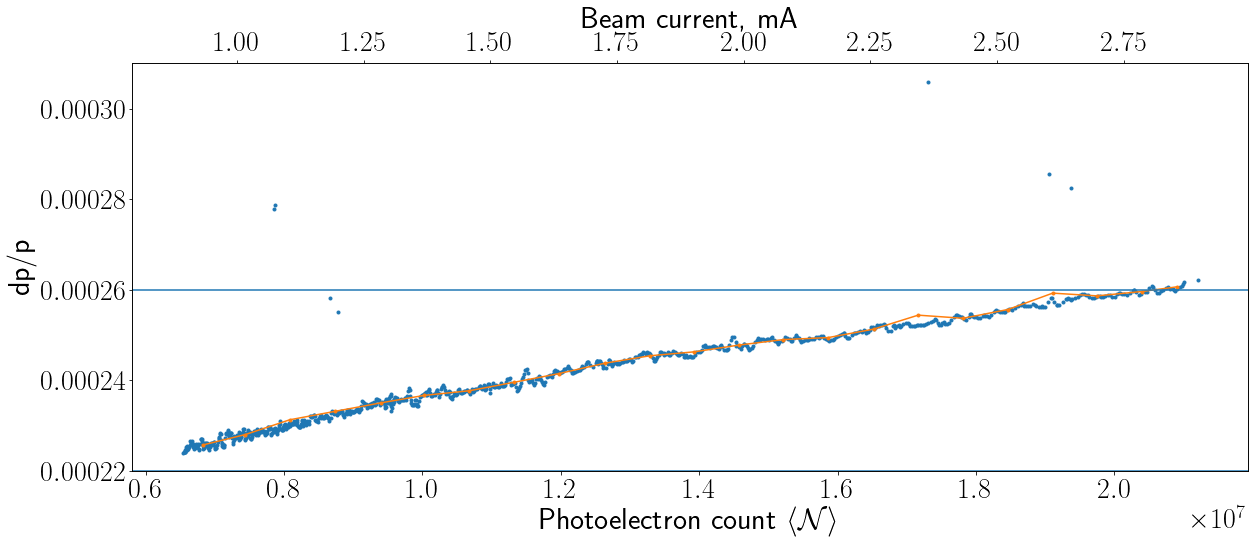

In [49]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['dp/p'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("dp/p")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['dp/p'] = df['dp/p']
dpp_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['dp/p'], bounds_error=False, fill_value="extrapolate")
dpp_interp = dpp_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
dpp_err_stat = np.std(first_injection['dp/p'].values-ey_interp)
ax.plot(photoel, df['dp/p'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
ax.axhline(2.2e-4)
ax.axhline(2.6e-4)
plt.show()

In [50]:
df_to_save = df_to_save.sort_values(by='N', ignore_index=True)
df_to_save

N  Sigma_um_X  Sigma_um_Y          sz_um    N:IRFEPA  \
0   6.822991e+06  465.800456  263.442764  242511.737997  357.571776   
1   7.442278e+06  470.868009  267.426168  245762.678713  357.624371   
2   8.084032e+06  478.592273  271.339028  248504.548094  357.723129   
3   8.735400e+06  481.047035  275.166796  251154.912227  357.790844   
4   9.403211e+06  483.627377  277.247745  254092.589367  357.823253   
5   1.002937e+07  489.576981  280.272400  255659.777833  357.886915   
6   1.067964e+07  496.408777  282.855439  256853.526855  358.003328   
7   1.132367e+07  498.631796  285.740379  259136.564602  358.043348   
8   1.196957e+07  500.781086  288.636649  261665.115601  358.108721   
9   1.263610e+07  502.086303  291.593880  264075.816348  358.198752   
10  1.328790e+07  506.639963  294.006639  266109.165007  358.280126   
11  1.392891e+07  509.015864  296.449522  267428.707311  358.290331   
12  1.457567e+07  512.324227  298.945849  269478.414616  358.443150   
13  1.521663e+07  515.787542  301.317027  270264.790317  358.480010   
14  1.586307e+07  519.502552  303.465820  271728.519690  358.563805   
15  1.652001e+07  522.223232  305.684828  273968.092319  358.557052   
16  1.716548e+07  525.521573  308.203108  275365.422311  358.638155   
17  1.781322e+07  526.320241  310.102005  277255.934062  358.771201   
18  1.846028e+07  531.171583  311.574674  278840.269354  358.852403   
19  1.910923e+07  535.037114  313.914065  280931.429940  358.920840   
20  1.974959e+07  536.624844  315.353176  282580.417115  358.963660   
21  2.039800e+07  538.651473  317.291372  284077.228085  359.029880   
22  2.091223e+07  540.267132  318.802389  285360.622244  358.968827   

    sz_cm_rms     ex_um     ey_um      dp/p  
0   26.576930  0.080929  0.070522  0.000226  
1   26.875539  0.082730  0.072671  0.000228  
2   27.106660  0.085552  0.074813  0.000231  
3   27.398785  0.086293  0.076938  0.000233  
4   27.684821  0.087076  0.078106  0.000235  
5   27.895971  0.089532  0.079819  0.000237  
6   27.990947  0.092593  0.081298  0.000238  
7   28.196495  0.093230  0.082964  0.000240  
8   28.481708  0.093824  0.084655  0.000241  
9   28.721718  0.093905  0.086398  0.000244  
10  28.933142  0.095754  0.087833  0.000245  
11  29.000363  0.096725  0.089299  0.000246  
12  29.167841  0.098011  0.090809  0.000248  
13  29.328617  0.099458  0.092255  0.000249  
14  29.375122  0.101237  0.093576  0.000249  
15  29.588257  0.102159  0.094949  0.000251  
16  29.718996  0.103032  0.096525  0.000254  
17  29.919030  0.103658  0.097713  0.000254  
18  30.095043  0.105680  0.098643  0.000256  
19  30.302058  0.106749  0.100133  0.000259  
20  30.470903  0.107760  0.101050  0.000259  
21  30.563409  0.108579  0.102296  0.000260  
22  30.688231  0.109159  0.103273  0.000261

In [51]:
df_to_save.to_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))

In [52]:
first_injection.to_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [53]:
first_injection

N:ITC1RSV   N:ITC1RSH   N:ITC2RSV   N:ITC2RSH  \
2020-03-16 13:48:46  450.873900  199.830990  180.712910  586.695980   
2020-03-16 13:48:47  450.754895  199.788245  180.648105  586.667995   
2020-03-16 13:48:48  450.635890  199.745500  180.583300  586.640010   
2020-03-16 13:48:49  450.484405  199.664895  180.457355  586.803005   
2020-03-16 13:48:50  450.332920  199.584290  180.331410  586.966000   
...                         ...         ...         ...         ...   
2020-03-16 14:05:08  367.083800  166.341890  149.685810  508.833010   
2020-03-16 14:05:09  367.718305  166.176745  150.042255  506.978500   
2020-03-16 14:05:10  368.352810  166.011600  150.398700  505.123990   
2020-03-16 14:05:11  368.234710  166.044155  150.230950  504.848495   
2020-03-16 14:05:12  368.116610  166.076710  150.063200  504.573000   

                      N:ITC3RSV   N:ITC3RSH  N:ITC4RSV  N:ITC4RSH   N:ITC4LSV  \
2020-03-16 13:48:46  272.539400  767.182010   105.9989    732.771  532.507020   
2020-03-16 13:48:47  272.397995  767.200015   105.9989    732.771  532.448515   
2020-03-16 13:48:48  272.256590  767.218020   105.9989    732.771  532.390010   
2020-03-16 13:48:49  272.117095  767.292510   105.9989    732.771  532.181515   
2020-03-16 13:48:50  271.977600  767.367000   105.9989    732.771  531.973020   
...                         ...         ...        ...        ...         ...   
2020-03-16 14:05:08  223.206190  658.341000   105.9989    732.771  449.975590   
2020-03-16 14:05:09  223.579140  656.404480   105.9989    732.771  449.332890   
2020-03-16 14:05:10  223.952090  654.467960   105.9989    732.771  448.690190   
2020-03-16 14:05:11  223.619700  655.029480   105.9989    732.771  447.935945   
2020-03-16 14:05:12  223.287310  655.591000   105.9989    732.771  447.181700   

                      N:ITC4LSH   N:ITC3LSV   N:ITC3LSH   N:ITC2LSV  \
2020-03-16 13:48:46  472.266600  271.746090  789.077030  180.630310   
2020-03-16 13:48:47  472.129350  271.538190  789.298005  180.566355   
2020-03-16 13:48:48  471.992100  271.330290  789.518980  180.502400   
2020-03-16 13:48:49  471.885500  271.318695  789.234985  180.447350   
2020-03-16 13:48:50  471.778900  271.307100  788.950990  180.392300   
...                         ...         ...         ...         ...   
2020-03-16 14:05:08  390.401090  216.642790  676.034000  148.813800   
2020-03-16 14:05:09  390.728790  217.218495  673.971530  149.039200   
2020-03-16 14:05:10  391.056490  217.794200  671.909060  149.264600   
2020-03-16 14:05:11  391.313445  217.743955  671.966035  149.282150   
2020-03-16 14:05:12  391.570400  217.693710  672.023010  149.299700   

                      N:ITC2LSH   N:ITC1LSV   N:ITC1LSH   N:IWCMBF   N:IWCMBR  \
2020-03-16 13:48:46  629.398010  551.085020  201.661100  65.611069  30.869360   
2020-03-16 13:48:47  629.325990  550.726500  201.707000  75.153669  33.265594   
2020-03-16 13:48:48  629.253970  550.367980  201.752900  85.897266  36.036870   
2020-03-16 13:48:49  629.196990  550.444490  201.625900  76.245254  33.635192   
2020-03-16 13:48:50  629.140010  550.521000  201.498900  65.337742  30.830237   
...                         ...         ...         ...        ...        ...   
2020-03-16 14:05:08  544.280030  443.441410  174.888210  55.666149  26.400883   
2020-03-16 14:05:09  542.638030  444.026155  174.469405  55.666149  26.400883   
2020-03-16 14:05:10  540.996030  444.610900  174.050600  55.666149  26.400883   
2020-03-16 14:05:11  539.929505  445.042540  173.631800  55.608524  26.412014   
2020-03-16 14:05:12  538.862980  445.474180  173.213000  55.713399  26.389055   

                      N:IWCMBP   N:IWCMI    N:IRFEPA    N:IRFEPP   N:IWCMBE  \
2020-03-16 13:48:46 -83.746559 -3.273680  359.093230  101.736840  28.638256   
2020-03-16 13:48:47 -83.653120 -2.991135  359.086791  101.710797  31.126353   
2020-03-16 13:48:48 -83.539501 -2.672711  359.010496  101.675489  33.941221   
2020-03-16 13:48:49 -83.670001 -2.941951  358.915880  

In [1]:
0.055/2/(150/0.511)**2*(1+1/2)

4.787218333333334e-07